In [6]:
!nvidia-smi

Fri Nov 17 10:15:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# from google.colab import files
# files.upload()

In [8]:
# import os

# # Set Kaggle API credentials as environment variables
# os.environ['KAGGLE_USERNAME'] = 'kmutnb'
# os.environ['KAGGLE_KEY'] = '2e8f3eec48ac90959791a330f9109431'

# import kaggle

# # Authenticate with Kaggle API
# kaggle.api.authenticate()

In [9]:
# !kaggle datasets download -d gpiosenka/sports-classification

In [10]:
# !unzip /content/sports-classification.zip -d data

In [11]:
!pip install vit-pytorch linformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.7 MB/s eta 0:00:00


In [12]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
train_data = "/content/data/train"
val_data = "/content/data/valid"

In [16]:
train_dataset = ImageFolder(train_data, transform=transform)
valid_dataset = ImageFolder(val_data, transform=transform)

In [17]:
batch_size = 16
# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [18]:
from vit_pytorch import ViT

v = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 100,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [19]:
# from torchvision.models import vit_b_16 as ViT, ViT_B_16_Weights
# model = ViT(weights=ViT_B_16_Weights.DEFAULT)

from torchvision.models import vit_l_32 as ViT, ViT_L_32_Weights
model = ViT(weights=ViT_L_32_Weights.DEFAULT)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/vit_l_32-c7638314.pth" to /root/.cache/torch/hub/checkpoints/vit_l_32-c7638314.pth
100%|██████████| 1.14G/1.14G [00:06<00:00, 193MB/s]


In [20]:
model._dropout = nn.Dropout(p=0.5)

In [21]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.Adam(model.parameters(), lr=0.000001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [22]:
# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [23]:
model_name = "ViT-"+str(batch_size)+"-15-nov-23"
# Training loop
num_epochs = 10
train_loss_list = []
valid_loss_list = []
train_accuracy_list = []
valid_accuracy_list = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = running_loss / len(valid_loader)
    valid_accuracy = correct / total

    # Store loss and accuracy values
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_accuracy_list.append(train_accuracy)
    valid_accuracy_list.append(valid_accuracy)

    # Print the training/validation statistics
    print(f"Epoch: {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_accuracy:.4f}")


    # Update the learning rate
    scheduler.step()

# Save the trained model
torch.save(model.state_dict(), model_name+".pth")

Epoch: 1/10 | Train Loss: 4.4179 | Train Acc: 0.0678 | Valid Loss: 3.5878 | Valid Acc: 0.1820
Epoch: 2/10 | Train Loss: 2.7575 | Train Acc: 0.3377 | Valid Loss: 1.9516 | Valid Acc: 0.5240
Epoch: 3/10 | Train Loss: 1.7384 | Train Acc: 0.5530 | Valid Loss: 1.4320 | Valid Acc: 0.6260
Epoch: 4/10 | Train Loss: 1.3537 | Train Acc: 0.6367 | Valid Loss: 1.2028 | Valid Acc: 0.6920
Epoch: 5/10 | Train Loss: 1.1606 | Train Acc: 0.6859 | Valid Loss: 1.0300 | Valid Acc: 0.7200
Epoch: 6/10 | Train Loss: 0.9471 | Train Acc: 0.7445 | Valid Loss: 0.9233 | Valid Acc: 0.7560
Epoch: 7/10 | Train Loss: 0.8673 | Train Acc: 0.7690 | Valid Loss: 0.8203 | Valid Acc: 0.7560
Epoch: 8/10 | Train Loss: 0.8198 | Train Acc: 0.7791 | Valid Loss: 0.7804 | Valid Acc: 0.7760
Epoch: 9/10 | Train Loss: 0.8216 | Train Acc: 0.7784 | Valid Loss: 0.7993 | Valid Acc: 0.7840
Epoch: 10/10 | Train Loss: 0.8052 | Train Acc: 0.7822 | Valid Loss: 0.8029 | Valid Acc: 0.7880


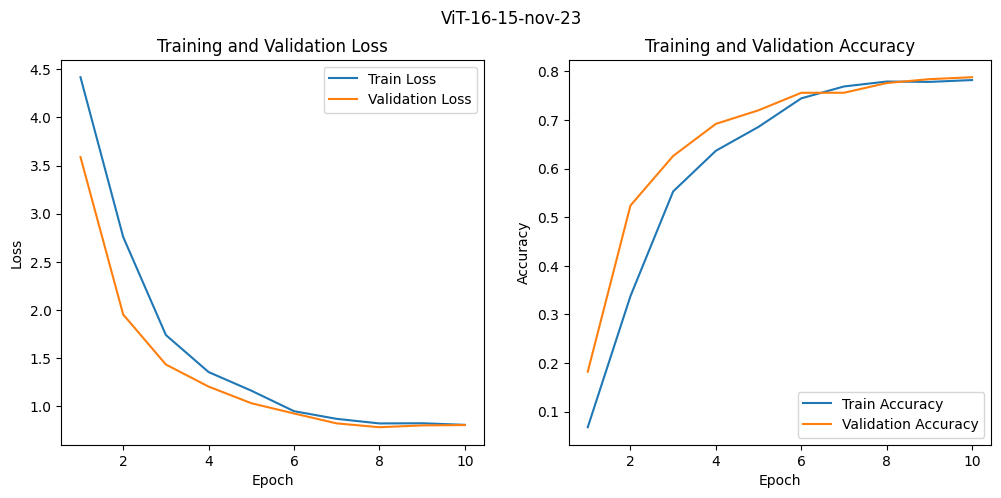

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Plot training and validation loss
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
# Plot training and validation accuracy
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), valid_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.suptitle(model_name)
plt.show()

In [25]:
# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []


# Validation loop
model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

valid_loss = running_loss / len(valid_loader)
valid_accuracy = correct / total


print(f"Epoch: {epoch+1}/{num_epochs} | "
      f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
      f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_accuracy:.4f}")


Epoch: 10/10 | Train Loss: 0.8052 | Train Acc: 0.7822 | Valid Loss: 1.5774 | Valid Acc: 0.7870


In [26]:
from sklearn.metrics import classification_report

# Generate classification report
classification_rep = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       1.00      0.80      0.89         5
           2       1.00      0.80      0.89         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       0.80      0.80      0.80         5
           6       1.00      1.00      1.00         5
           7       0.83      1.00      0.91         5
           8       0.80      0.80      0.80         5
           9       0.67      0.80      0.73         5
          10       1.00      1.00      1.00         5
          11       0.75      0.60      0.67         5
          12       0.67      0.80      0.73         5
          13       1.00      0.40      0.57         5
          14       1.00      0.40      0.57         5
          15       0.83      1.00      0.91         5
          16       0.83      1.00      0.91         5
    

<Figure size 800x500 with 0 Axes>

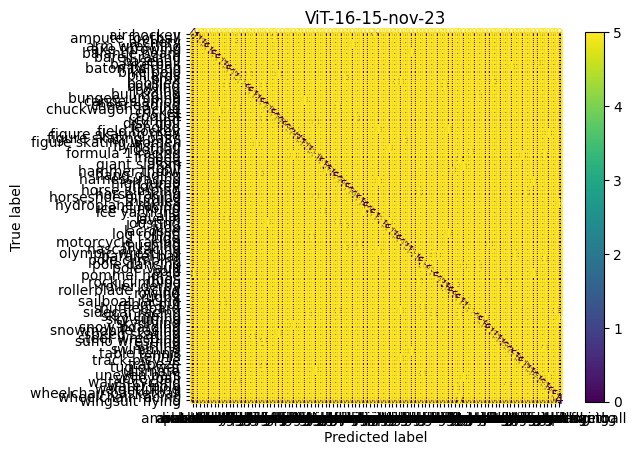

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_dataset.classes)
cm_display.plot()

plt.title(model_name)



plt.show()